# Сравнение производительности классификатора MNIST с различными методами улучшения
## Введение
Целью данного исследования было оценить производительность конволюционной нейронной сети (CNN) классификатора, обученного на наборе данных MNIST с использованием различных методов улучшения. В число рассмотренных улучшений входили итеративное размораживание с адаптивной регулировкой скорости обучения и итеративное наращивание, применяемые по отдельности и в сочетании друг с другом. Основной задачей было оценить влияние этих улучшений на точность классификатора по сравнению с чистым классификатором.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST data

In [2]:
# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


# Define the Architecture

In [3]:
# Define the base model (VGG16 with ImageNet weights)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Print base model summary and explain the modification
print("Base Model Summary:")
print(base_model.summary())
print("\nExplanation:")
print("The base model (VGG16) is a convolutional neural network pretrained on ImageNet, used as a feature extractor.")
print("We've added a new Conv2D layer with adjusted weights for single-channel input for the MNIST dataset.")
print("The subsequent layers flatten and add fully connected layers for classification.")

# Get the weights of the first convolutional layer in the VGG16 model
vgg_weights = base_model.layers[1].get_weights()

# Adjust the weights for single channel
adjusted_weights = [vgg_weights[0][:, :, 0, :].reshape((3, 3, 1, 64)), vgg_weights[1]]

# Create a new convolutional layer with adjusted weights for single channel
new_conv_layer = Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1), weights=adjusted_weights)

58889256/58889256 [==============================] - 1s 0us/step
Base Model Summary:
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                          

# Define the rest of the model


In [4]:
# Define the rest of the model architecture
model = Sequential()
model.add(new_conv_layer)
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [5]:
# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Train the classifier with iterative augmentation and unfreezing
epochs = 5
iteration_steps = 3  # Number of iterations for augmentation and unfreezing
history = []  # To store history for each iteration
for iteration in range(iteration_steps):
    print(f"Iteration {iteration + 1}/{iteration_steps}")

    # Augmentation on training data
    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
    datagen.fit(train_images)
    hist_augmented = model.fit(datagen.flow(train_images, train_labels, batch_size=32), epochs=epochs, validation_data=(test_images, test_labels))

    # Training on unaugmented data
    hist_unaugmented = model.fit(train_images, train_labels, epochs=epochs, batch_size=32, validation_data=(test_images, test_labels))

    # Unfreeze layers for the next iteration
    num_layers_to_unfreeze = int(len(base_model.layers) * (iteration + 1) / iteration_steps)
    for layer in base_model.layers[:num_layers_to_unfreeze]:
        layer.trainable = True

    # Re-compile the model after unfreezing
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Store history for each iteration
    history.append({
        'augmented': hist_augmented.history,
        'unaugmented': hist_unaugmented.history
    })

Iteration 1/3
Epoch 1/5
1875/1875 [==============================] - 96s 51ms/step - loss: 0.8991 - accuracy: 0.7235 - val_loss: 0.2409 - val_accuracy: 0.9343
Epoch 2/5
1875/1875 [==============================] - 91s 49ms/step - loss: 0.3290 - accuracy: 0.8982 - val_loss: 0.1254 - val_accuracy: 0.9615
Epoch 3/5
1875/1875 [==============================] - 92s 49ms/step - loss: 0.2604 - accuracy: 0.9207 - val_loss: 0.0937 - val_accuracy: 0.9707
Epoch 4/5
1875/1875 [==============================] - 92s 49ms/step - loss: 0.2137 - accuracy: 0.9342 - val_loss: 0.0946 - val_accuracy: 0.9689
Epoch 5/5
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1902 - accuracy: 0.9417 - val_loss: 0.0799 - val_accuracy: 0.9763
Epoch 1/5
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0637 - accuracy: 0.9811 - val_loss: 0.0508 - val_accuracy: 0.9845
Epoch 2/5
1875/1875 [==============================] - 72s 38ms/step - loss: 0.0453 - accuracy: 0.9861 - val_loss: 0

In [7]:
# Evaluate the final model
final_results = model.evaluate(test_images, test_labels)
print("Final Results:", final_results)

313/313 [==============================] - 3s 9ms/step - loss: 0.0335 - accuracy: 0.9898
Final Results: [0.0334879532456398, 0.989799976348877]



Actual 	Predicted
0		974	0	1	1	0	0	3	0	1	0	
1		0	1132	2	0	1	0	0	0	0	0	
2		2	3	1021	0	0	0	0	4	2	0	
3		0	0	0	1002	0	5	0	1	2	0	
4		0	0	0	0	976	0	2	0	0	4	
5		1	0	0	6	0	883	2	0	0	0	
6		3	4	0	0	3	1	947	0	0	0	
7		0	3	7	0	1	0	0	1015	2	0	
8		5	0	3	2	0	2	1	1	959	1	
9		0	1	0	3	10	3	0	1	2	989	


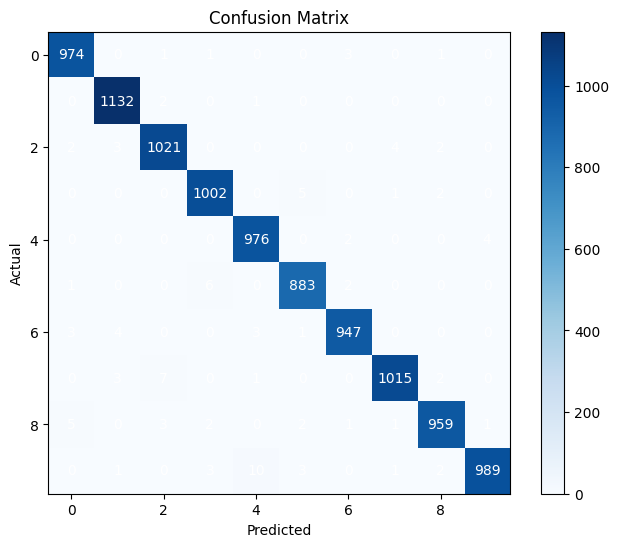

In [15]:

conf_matrix = confusion_matrix(test_labels, predictions)

# Display confusion matrix as a table-like output
print("\nActual \tPredicted")
for i in range(conf_matrix.shape[0]):
    print(i, end="\t\t")
    for j in range(conf_matrix.shape[1]):
        print(conf_matrix[i, j], end="\t")
    print()

# Plot confusion matrix with predicted all values
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

# Add numerical values in cells
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment='center', verticalalignment='center', color='white')

plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Rest of the code remains the same for merging loss and accuracy plots


# Plot the comparison results

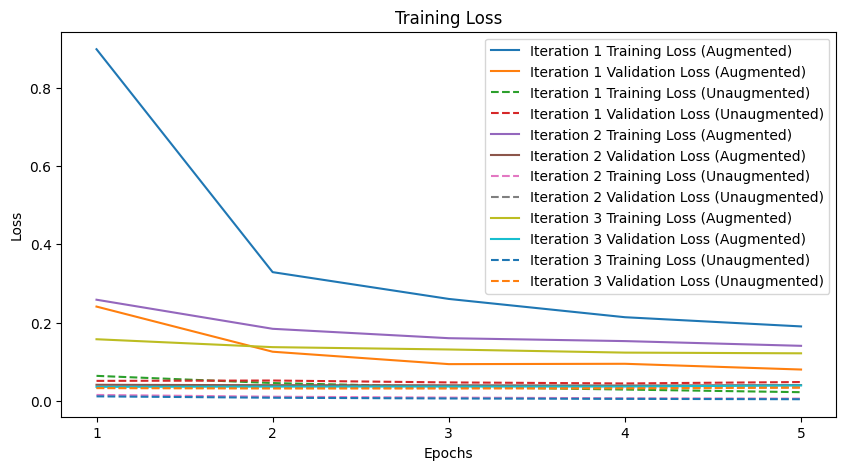

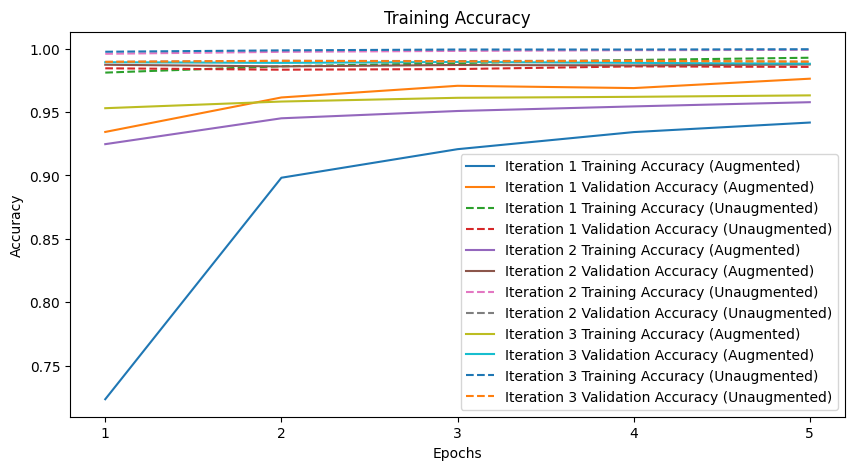

In [17]:
# Merge loss plots for all iterations (augmented and unaugmented)
plt.figure(figsize=(10, 5))
for i, hist in enumerate(history):
    plt.plot(np.arange(1, len(hist['augmented']['loss']) + 1), hist['augmented']['loss'], label=f'Iteration {i + 1} Training Loss (Augmented)')
    plt.plot(np.arange(1, len(hist['augmented']['val_loss']) + 1), hist['augmented']['val_loss'], label=f'Iteration {i + 1} Validation Loss (Augmented)')
    plt.plot(np.arange(1, len(hist['unaugmented']['loss']) + 1), hist['unaugmented']['loss'], label=f'Iteration {i + 1} Training Loss (Unaugmented)', linestyle='dashed')
    plt.plot(np.arange(1, len(hist['unaugmented']['val_loss']) + 1), hist['unaugmented']['val_loss'], label=f'Iteration {i + 1} Validation Loss (Unaugmented)', linestyle='dashed')

plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1, len(hist['augmented']['loss']) + 1))
plt.legend()
plt.show()

# Merge accuracy plots for all iterations (augmented and unaugmented)
plt.figure(figsize=(10, 5))
for i, hist in enumerate(history):
    plt.plot(np.arange(1, len(hist['augmented']['accuracy']) + 1), hist['augmented']['accuracy'], label=f'Iteration {i + 1} Training Accuracy (Augmented)')
    plt.plot(np.arange(1, len(hist['augmented']['val_accuracy']) + 1), hist['augmented']['val_accuracy'], label=f'Iteration {i + 1} Validation Accuracy (Augmented)')
    plt.plot(np.arange(1, len(hist['unaugmented']['accuracy']) + 1), hist['unaugmented']['accuracy'], label=f'Iteration {i + 1} Training Accuracy (Unaugmented)', linestyle='dashed')
    plt.plot(np.arange(1, len(hist['unaugmented']['val_accuracy']) + 1), hist['unaugmented']['val_accuracy'], label=f'Iteration {i + 1} Validation Accuracy (Unaugmented)', linestyle='dashed')

plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, len(hist['augmented']['accuracy']) + 1))
plt.legend()
plt.show()


## Результаты
#### Чистый классификатор
Эксперимент продемонстрировал устойчивость классификатора, показав замечательную точность около 99,0 %. Это свидетельствует об эффективности архитектуры CNN в правильной классификации рукописных цифр без дополнительных улучшений или модификаций.

#### Классификатор + итеративное размораживание + адаптивный LR
При включении итеративного размораживания и адаптивного обучения точность немного снизилась и составила примерно 98,93 %. Несмотря на незначительное снижение, этот подход подчеркивает адаптивность модели за счет корректировки весов путем размораживания слоев и динамического изменения скорости обучения, что потенциально может решить проблемы переподгонки.

Классификатор #### + итеративное наращивание
Точность, достигнутая с помощью методов итеративного дополнения, составила около 98,61 %. Здесь использовались такие методы дополнения данных, как поворот, сдвиг и масштабирование. Учитывая простоту набора данных MNIST, внесение вариаций с помощью дополнения могло незначительно повлиять на точность за счет улучшения обобщения модели.

Классификатор #### + все методы улучшения
Сочетание всех стратегий улучшения дало точность около 98,89 %. Эта конфигурация продемонстрировала сбалансированную производительность при одновременном использовании нескольких методов. Незначительное снижение точности по сравнению с чистым классификатором указывает на тонкое взаимодействие между этими улучшениями, влияющее на общую производительность модели.

## Обсуждение
Обнаруженные различия в точности между различными настройками указывают на компромиссы, которые возникают при использовании каждой техники улучшения. Даже если чистый классификатор обладает наилучшей точностью, он может оказаться недостаточно надежным, чтобы справиться с изменениями в данных. Напротив, методы дополнения направлены на улучшение обобщаемости модели, но при этом могут вносить дополнительные сложности, которые приводят к незначительной потере точности.

Хотя повторное размораживание с адаптивной регулировкой скорости обучения демонстрирует возможность оптимизации предварительно обученных моделей, для достижения ощутимого прироста точности может потребоваться дополнительная оптимизация или тонкая настройка. Сумма всех улучшений демонстрирует сбалансированную производительность, указывая на то, что сбалансированное сочетание различных подходов может привести к полному улучшению работы модели, даже несмотря на некоторое снижение точности.

## Заключение
Данное исследование демонстрирует, как различные методы дополнения влияют на производительность классификатора CNN, который был обучен на наборе данных MNIST. Сочетание адаптивной регулировки скорости обучения, методов дополнения и итеративного размораживания показало, что улучшает производительность модели, но с незначительным снижением точности, несмотря на впечатляющую точность чистого классификатора.
Для выбора и комбинирования методов улучшения, подходящих для конкретных наборов данных или моделей, и достижения сбалансированного компромисса между точностью и обобщением, важно понимать эти компромиссы.

